In [1]:
CODE_PATH = '../../code/'
UKBB_DATA_PATH = '../../data/ukbb/'
BASE_LOG_PATH = '../../models/ukbb/SVIExperiment/'
FIGURE_SAVE_PATH = 'figures'

# Setup

In [2]:
%matplotlib inline
import sys
import os

sys.path.append(CODE_PATH)

os.environ['CUDA_VISIBLE_DEVICES'] = ''

import torch
import pyro
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import inspect
from collections import OrderedDict
from functools import partial
import torch

from tqdm import tqdm, trange

import traceback
import warnings
from scipy.stats import gaussian_kde

warnings.filterwarnings("ignore", category=UserWarning)

torch.autograd.set_grad_enabled(False);

os.makedirs(FIGURE_SAVE_PATH, exist_ok=True)

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmaps = [cm.Reds, cm.Blues, cm.Greens]
img_cm = 'Greys_r'
diff_cm = 'seismic'

In [4]:
from datasets.medical.ukbb import UKBBDataset

data_dir = f'{UKBB_DATA_PATH}/test.csv'
downsample = 3
ukbb_test = UKBBDataset(data_dir, crop_type='center', downsample=downsample)

In [5]:
from experiments.medical import ukbb  # noqa: F401
from experiments.medical.base_experiment import EXPERIMENT_REGISTRY, MODEL_REGISTRY

In [6]:
var_name = {'ventricle_volume': 'v', 'brain_volume': 'b', 'sex': 's', 'age': 'a'}
value_fmt = {
    'ventricle_volume': lambda s: rf'{float(s)/1000:.4g}\,\mathrm{{ml}}',
    'brain_volume': lambda s: rf'{float(s)/1000:.4g}\,\mathrm{{ml}}',
    'age': lambda s: rf'{int(s):d}\,\mathrm{{y}}',
    'sex': lambda s: '{}'.format(['\mathrm{female}', '\mathrm{male}'][int(s)])
}

def fmt_intervention(intervention):
    if isinstance(intervention, str):
        var, value = intervention[3:-1].split('=')
        return f"$do({var_name[var]}={value_fmt[var](value)})$"
    else:
        all_interventions = ', '.join([f'{var_name[k]}={value_fmt[k](v)}' for k, v in intervention.items()])
        return f"$do({all_interventions})$"

In [7]:
def prep_data(batch):
    x = batch['image'].unsqueeze(0) * 255.
    age = batch['age'].unsqueeze(0).unsqueeze(0).float()
    sex = batch['sex'].unsqueeze(0).unsqueeze(0).float()
    ventricle_volume = batch['ventricle_volume'].unsqueeze(0).unsqueeze(0).float()
    brain_volume = batch['brain_volume'].unsqueeze(0).unsqueeze(0).float()

    x = x.float()

    return {'x': x, 'age': age, 'sex': sex, 'ventricle_volume': ventricle_volume, 'brain_volume': brain_volume}

# Metrics

In [8]:
columns = [
    'exp', 'loss', 'log p(x)', 'log p(age)', 'log p(sex)', 'log p(ventricle_volume)',
    'log p(brain_volume)', 'log p(z) - log q(z)', 'p(z)', 'q(z)'
]
metrics_df = pd.DataFrame(columns=columns)
experiments = ['ConditionalVISEM']

In [9]:
version = 3
for exp in experiments:
    try:
        print(exp)
        metrics = torch.load(f'{BASE_LOG_PATH}/{exp}/version_0/metrics.pt')
        for k, v in metrics.items():
            print(f'{k}: {v:.0f}')
        row = {k.replace('test/', ''): np.array(v) for k, v in metrics.items()}
        metrics_df.loc[len(metrics_df)] = {'exp': exp, **row}
    except:
        pass

ConditionalVISEM
test/loss: 2281463
test/log p(x): -36014
test/log p(age): -3
test/log p(sex): -1
test/log p(ventricle_volume): -11
test/log p(brain_volume): -13
test/p(z): -96
test/q(z): 327
test/log p(z) - log q(z): -423


In [10]:
recon_mae = {}
for exp in experiments:
    try:
        reconstructions = torch.load(f'{BASE_LOG_PATH}/{exp}/version_0/reconstruction.pt')
        diff = []
        for i in trange(reconstructions['x'].shape[0]):
            diff += [reconstructions['x'][i] - (ukbb_test[i]['image'] * 255.)]
        recon_mae[exp] = np.mean(np.abs(torch.stack(diff).numpy()))
    except Exception as e:
        print(e)
    
metrics_df.loc[:, 'recon_mae'] = list(recon_mae.values())

100%|██████████| 2063/2063 [00:09<00:00, 221.28it/s]


In [11]:
metrics_df

,exp,loss,log p(x),log p(age),log p(sex),log p(ventricle_volume),log p(brain_volume),log p(z) - log q(z),p(z),q(z),recon_mae
0,ConditionalVISEM,2281462.575620709,-36013.92,-3.2752993,-0.69422126,-10.802368,-12.843012,-423.35135,-96.38654,326.96484,8.599537


# Loaded Models

In [12]:
models = {}
loaded_models = {}

for exp in experiments:
    try:
        checkpoint_path = f'{BASE_LOG_PATH}/{exp}/version_0/'

        base_path = os.path.join(checkpoint_path, 'checkpoints')
        checkpoint_path = os.path.join(base_path, os.listdir(base_path)[0])

        ckpt = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        hparams = ckpt['hparams']
        
        model_class = MODEL_REGISTRY[hparams['model']]

        model_params = {
            k: v for k, v in hparams.items() if (k in inspect.signature(model_class.__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__bases__[0].__init__).parameters)
        }
        
        new_state_dict = OrderedDict()

        for key, value in ckpt['state_dict'].items():
            new_key = key.replace('pyro_model.', '')
            new_state_dict[new_key] = value
            
        loaded_model = model_class(**model_params)
        loaded_model.load_state_dict(new_state_dict)
        
        for p in loaded_model._buffers.keys():
            if 'norm' in p:
                setattr(loaded_model, p, getattr(loaded_model, p))
                
        loaded_model.eval()
                
                
        loaded_models[exp] = loaded_model
        
        def sample_pgm(num_samples, model):
            with pyro.plate('observations', num_samples):
                return model.pgm_model()
        
        models[exp] = partial(sample_pgm, model=loaded_model)
    except Exception as e:
        print(e)
        traceback.print_exc()

# Dataset Samples

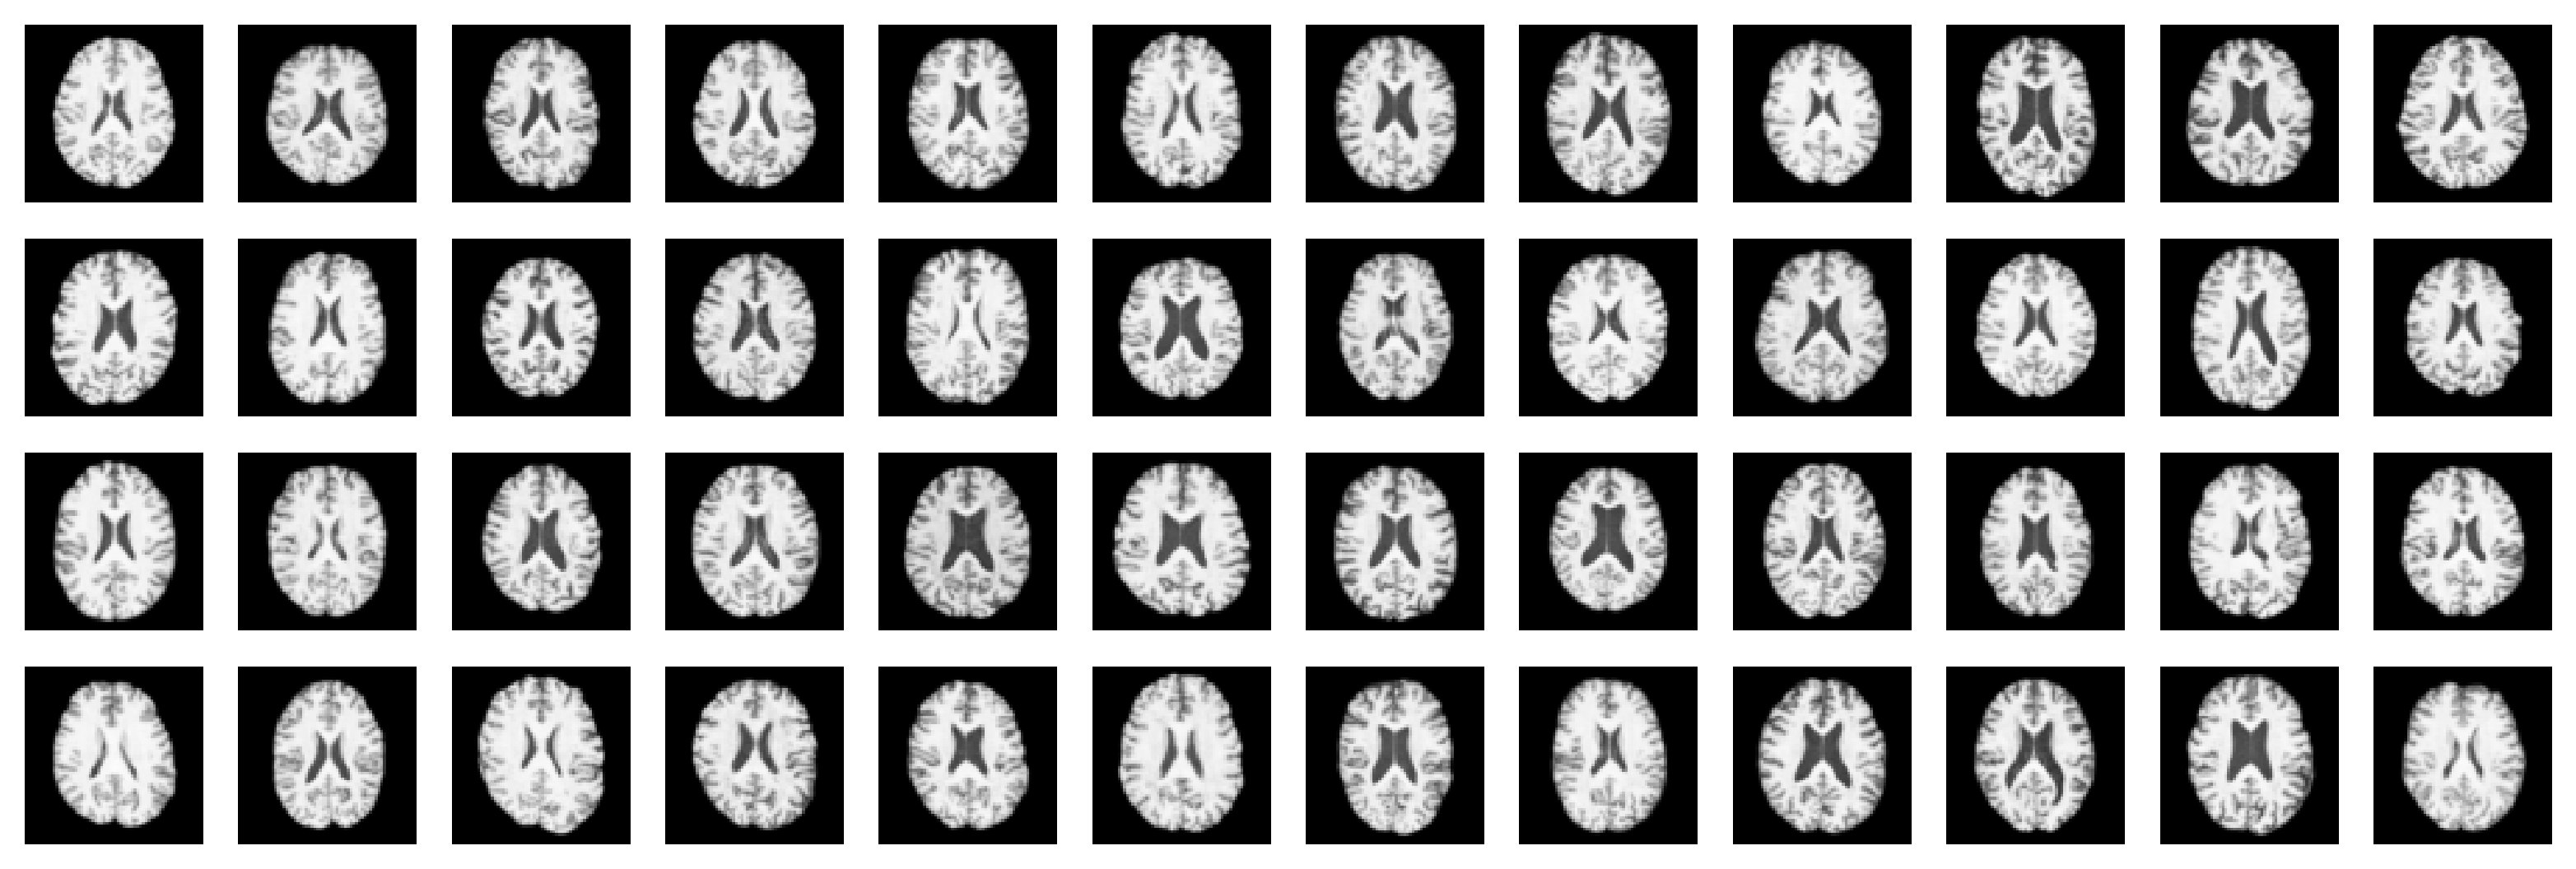

In [13]:
num_cols = 12
num_rows = 4
num = num_cols * num_rows

fig = plt.figure(figsize=(num_cols * 1.1, num_rows * 1.1))
gs = fig.add_gridspec(num_rows, num_cols, wspace=.2, hspace=.2)

save_name = 'ukbb_samples'

for i in range(num):
    d = ukbb_test[i]['image'] * 255
    
    ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
    ax.imshow(d.numpy().squeeze(), img_cm, vmin=0, vmax=255)
    ax.axis('off')

    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

# Unconditional Samples

ConditionalVISEM


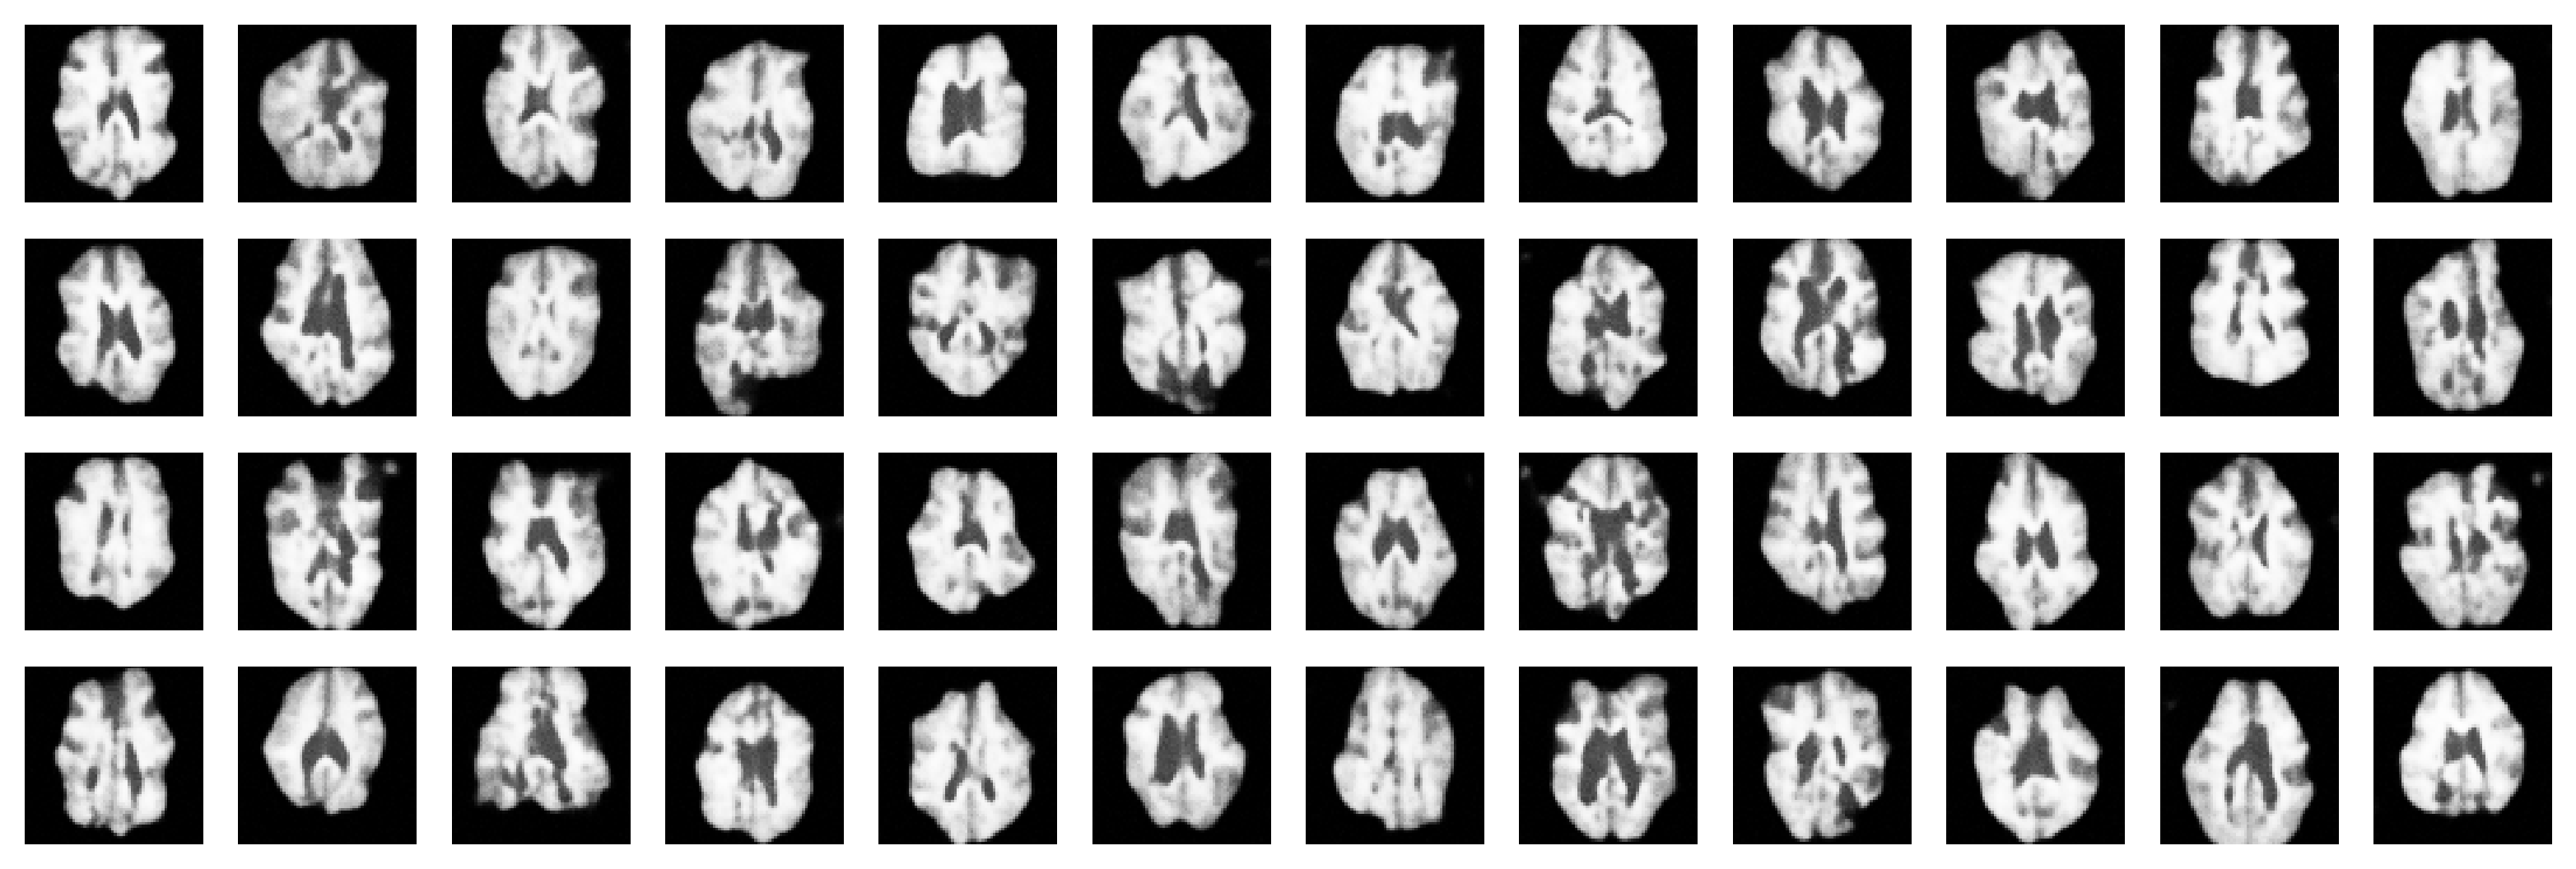

In [14]:
num_cols = 12
num_rows = 4
num = num_cols * num_rows


for exp in loaded_models.keys():
    print(exp)

    samples = loaded_models[exp].sample(num)
        
    samples = {
        'x': samples[0],
    }
    
    save_name = f'{exp}_uncond_samples'

    fig = plt.figure(figsize=(num_cols * 1.1, num_rows * 1.1))
    gs = fig.add_gridspec(num_rows, num_cols, wspace=.2, hspace=.2)

    for i in range(num):
        x = samples['x'][i]
        
        ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
        ax.imshow(x.numpy().squeeze(), img_cm, vmin=0, vmax=255)
        ax.axis('off')
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.pdf", bbox_inches='tight', pad_inches=0)
    
    plt.show()

# Conditional Samples

ConditionalVISEM


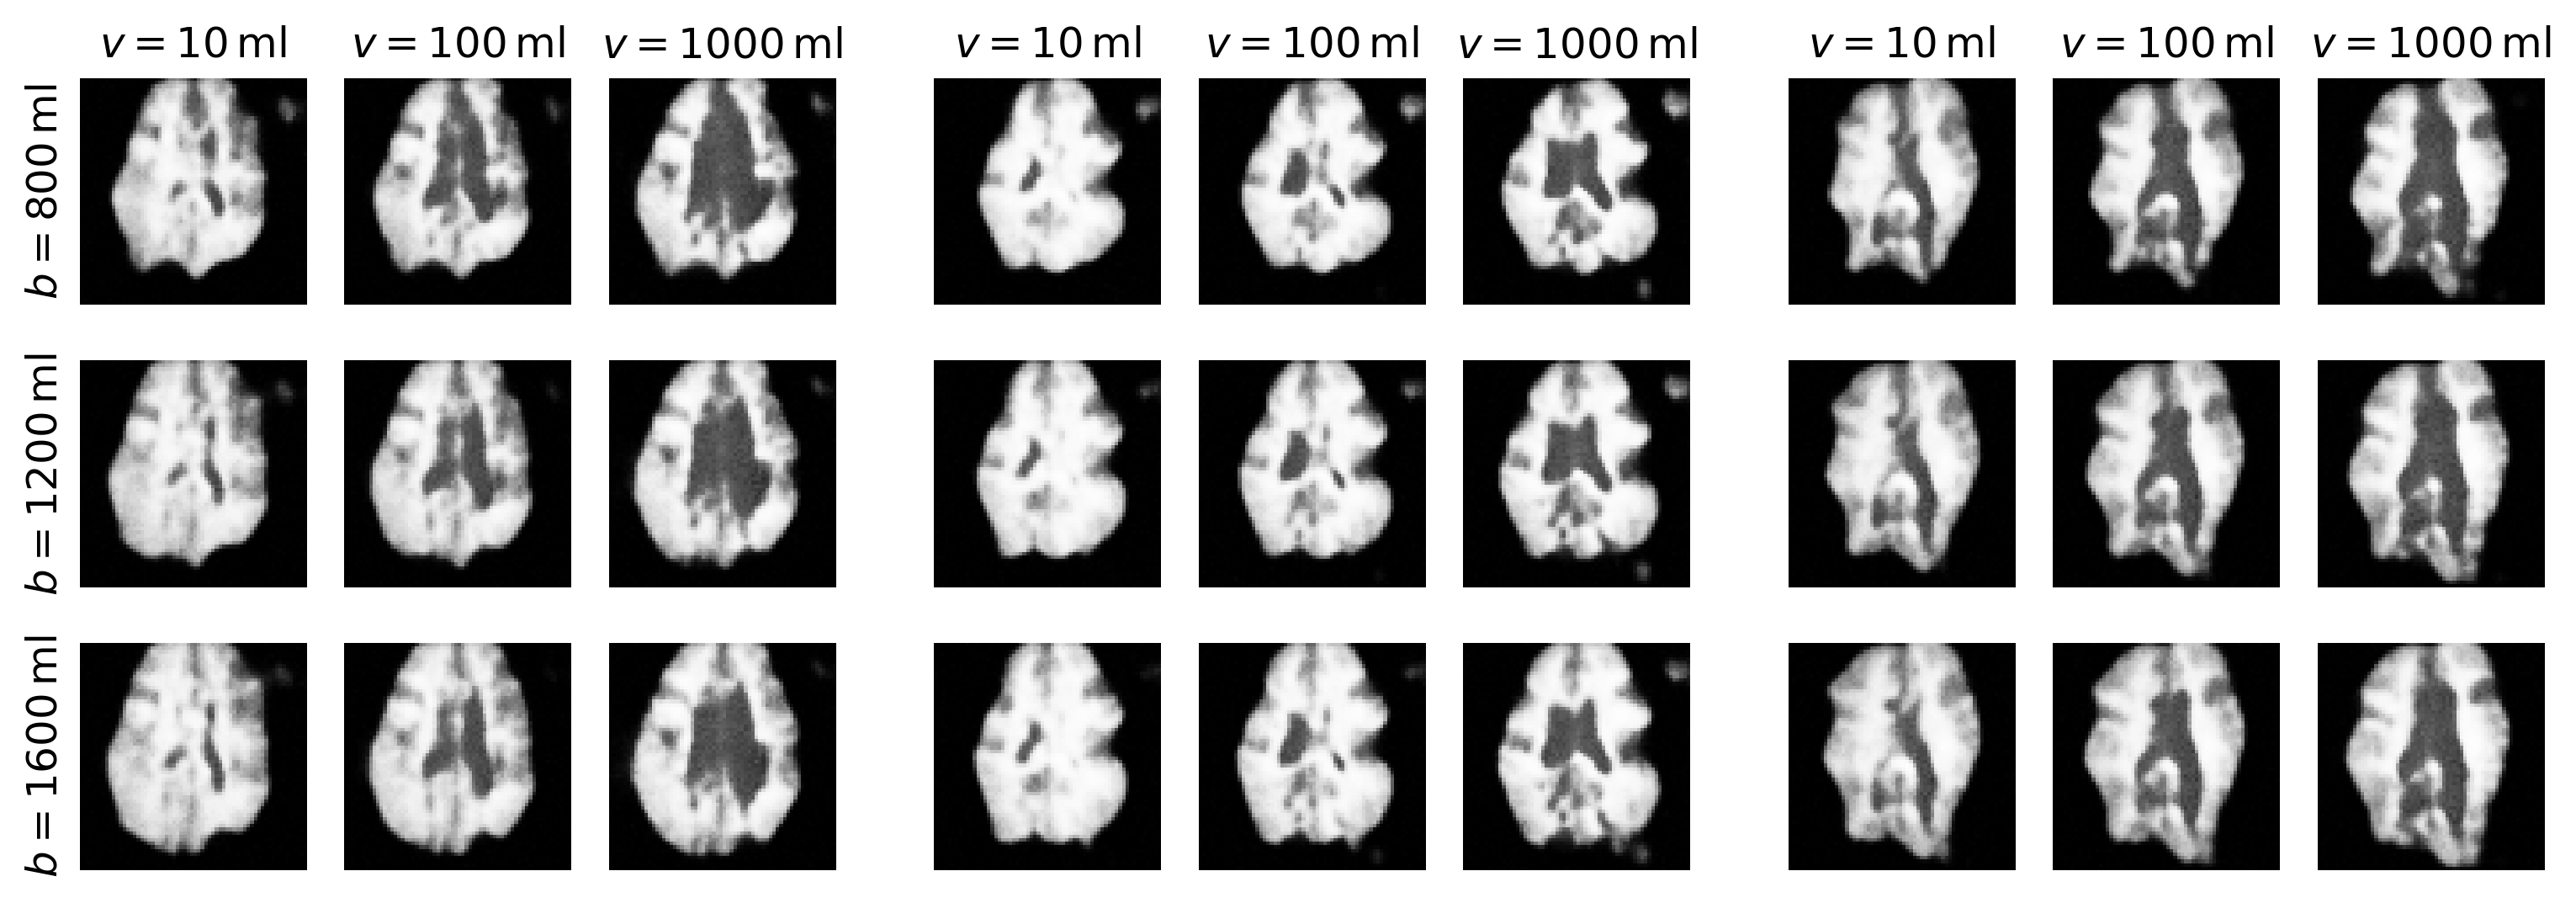

In [15]:
exp = 'ConditionalVISEM'

print(exp)

b_range = [800000., 1200000., 1600000.]
v_range = [10000., 100000., 1000000.]

samples = {
    'x': [],
    'brain_volume': [],
    'ventricle_volume': [],

}

save_name = f'{exp}_cond_samples'

num_ex = 3
num_cols = len(b_range)
num_rows = len(v_range)
num = num_ex * num_cols * num_rows

fig = plt.figure(figsize=(num_ex * num_cols * 1.4, num_rows * 1.4))

width_ratios = [0.1 if ((i + 1) % (num_cols + 1)) == 0 else 1 for i in range(num_ex * num_cols + num_ex - 1)]
gs = fig.add_gridspec(num_rows, num_ex * num_cols + num_ex - 1, wspace=.2, hspace=.2, width_ratios=width_ratios)


for _ in range(num_ex):
    z = loaded_models[exp].sample(1)[1]

    for i, brain_volume in enumerate(b_range):
        for j, ventricle_volume in enumerate(v_range):
            brain_volume = torch.tensor([[brain_volume]])
            ventricle_volume = torch.tensor([[ventricle_volume]])
            data = {'z': z, 'brain_volume': brain_volume, 'ventricle_volume': ventricle_volume}

            x, *_ = pyro.condition(loaded_models[exp].sample, data=data)(1)
            samples['x'] += [x]
            samples['brain_volume'] += [brain_volume]
            samples['ventricle_volume'] += [ventricle_volume]



for i in range(num):
    cur_ex = i // (num_cols * num_rows)
    cur_row = (i - cur_ex * num_cols * num_rows) // num_cols
    cur_col = i % num_cols
    
    x = samples['x'][i]

    ax = fig.add_subplot(gs[cur_row, cur_col + cur_ex * (num_cols + 1)])
    ax.imshow(x.numpy().squeeze(), img_cm, vmin=0, vmax=255)
    if cur_col == 0 and cur_ex == 0:
        brain_volume = samples['brain_volume'][i].item()
        ax.set_ylabel('$b={}$'.format(value_fmt['brain_volume'](brain_volume)),
                      fontsize=mpl.rcParams['axes.titlesize'])
        for s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax.spines[s].set_visible(False)
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
        plt.setp(ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.axis('off')
    if cur_row == 0:
        ventricle_volume = samples['ventricle_volume'][i].item()
        ax.set_title('$v={}$'.format(value_fmt['ventricle_volume'](ventricle_volume)))
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

# Reconstructions

ConditionalVISEM


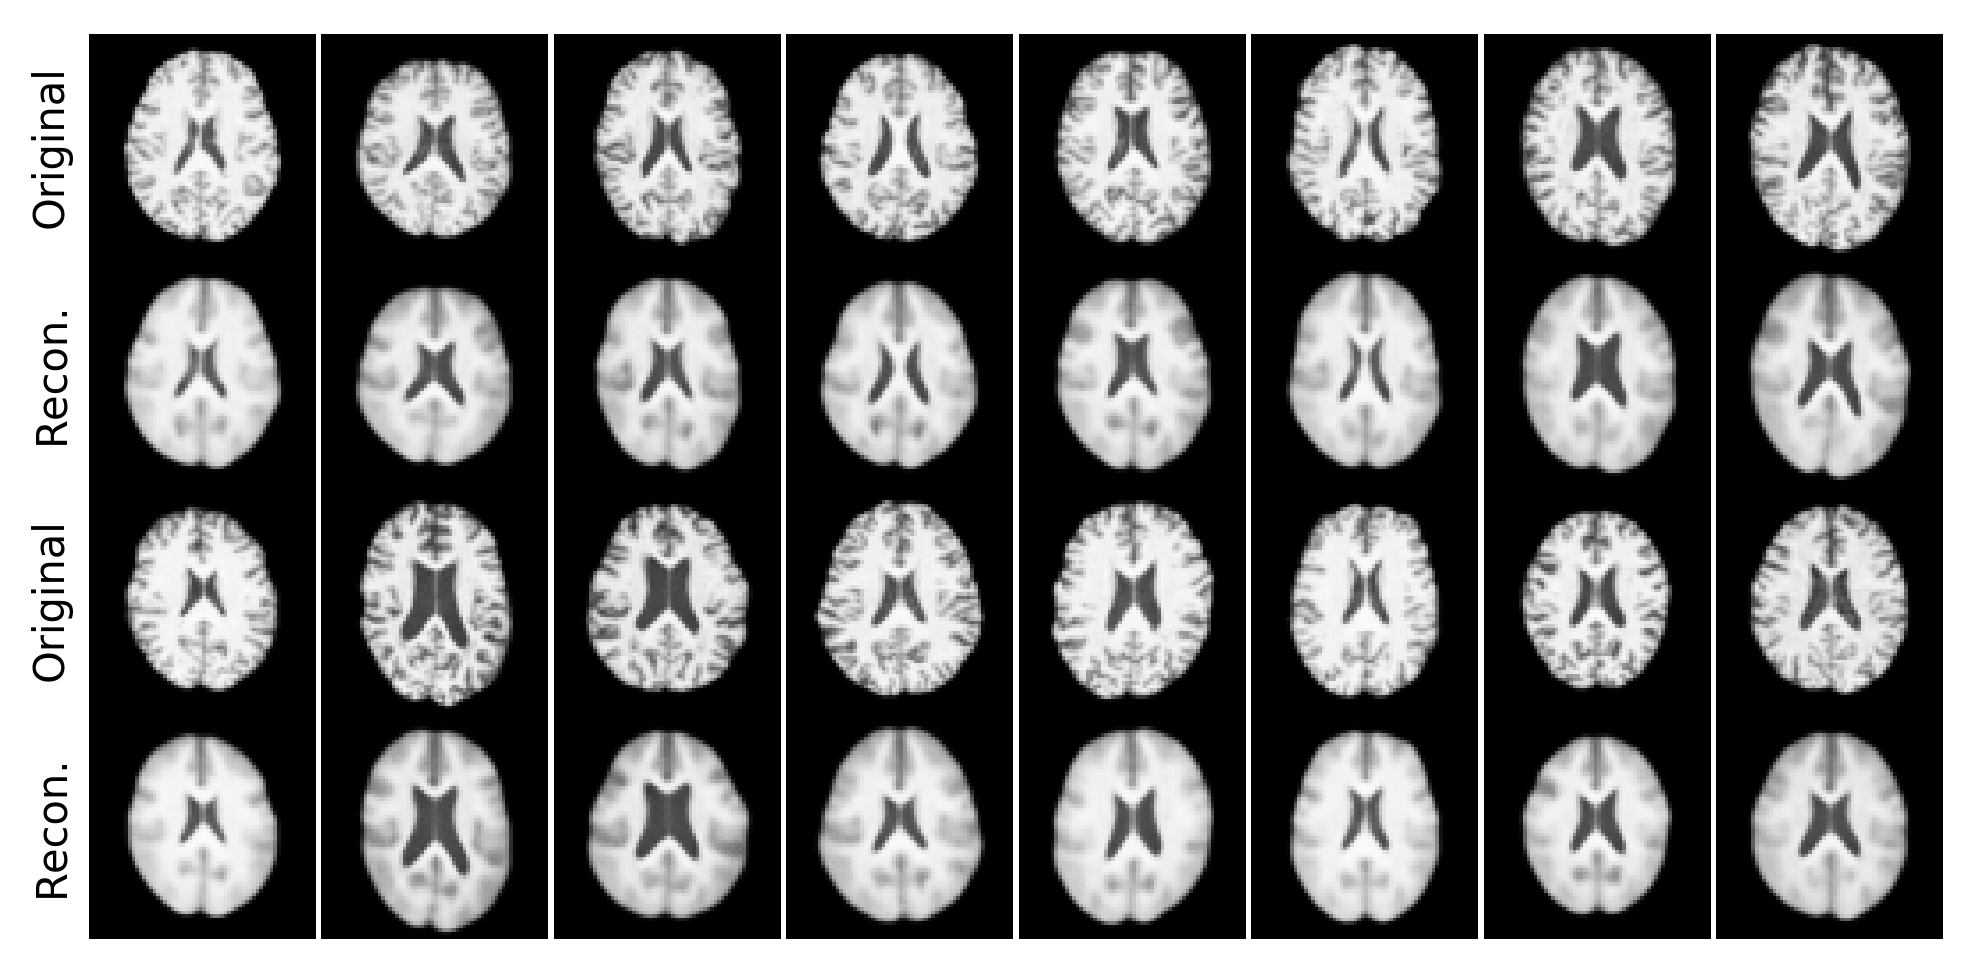

In [16]:
num_samples = 8
num_rows = 2

titles = {
    'ConditionalVISEM': 'Full',
}

save_name = 'reconstructions'

fig = plt.figure(figsize=(num_samples * 1., 2. * num_rows))

gs = fig.add_gridspec(2 * num_rows, num_samples, wspace=0., hspace=0.0)

for i in range(num_samples * num_rows):
    col = i % num_samples
    row = i // num_samples
    
    img = ukbb_test[i]['image'] * 255
    
    ax = fig.add_subplot(gs[row * 2, col])
    ax.imshow(img.numpy().squeeze(), img_cm, vmin=0, vmax=255)
    if col == 0:
        ax.set_ylabel('Original')
        for s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax.spines[s].set_visible(False)
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
        plt.setp(ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.axis('off')
        
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

exp = 'ConditionalVISEM'
print(exp)
reconstructions = torch.load(f'{BASE_LOG_PATH}/{exp}/version_0/reconstruction.pt')

for i in range(num_samples * num_rows):
    col = i % num_samples
    row = i // num_samples

    img = reconstructions['x'][i]

    ax = fig.add_subplot(gs[row * 2 + 1, col])
    ax.imshow(img.numpy().squeeze(), img_cm, vmin=0, vmax=255)
    if col == 0:
        ax.set_ylabel('Recon.')
        for s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax.spines[s].set_visible(False)
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
        plt.setp(ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.axis('off')

    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
            
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

# Age, Brain, Sex KDE

In [17]:
model_name = 'ConditionalVISEM'

def pgm_model(n):
    with pyro.plate('observations', n):
        return loaded_models[model_name].pgm_model()
    
def plot_joint_pdf(x, y, logp, ax=None):
    if ax is None:
        ax = plt.gca()
    prob = logp.exp().numpy().T
    mi = prob.min()
    ma = np.percentile(prob.flat, 99.5)
    step = (ma - mi) / 5
    levels = np.arange(mi, ma, step) + step
    ax.contourf(x, y, prob, cmap=cmaps[0], levels=levels, antialiased=True, extend='max')
    
age_range = torch.arange(45, 75, 0.1, dtype=torch.float)
bvol_range = torch.arange(8e5, 16e5, 5e3, dtype=torch.float)
vvol_range = torch.arange(0, 1.5e5, 1e3, dtype=torch.float)

age_range_, bvol_range_ = [x.reshape(-1, 1) for x in torch.meshgrid(age_range, bvol_range)]

prob_maps = {'model': {}}
for sex in [0, 1]:
    cond_data = {
        'age': age_range_,
        'brain_volume': bvol_range_,
        'sex': torch.tensor(float(sex)).expand(age_range_.shape)
    }

    with torch.no_grad():
        trace = pyro.poutine.trace(pyro.condition(pgm_model, data=cond_data)).get_trace(age_range_.shape[0])
        trace.compute_log_prob()

    log_prob = trace.nodes['age']['log_prob'] + trace.nodes['brain_volume']['log_prob']
    prob_maps['model'][f"$s=\mathrm{{{['female', 'male'][sex]}}}$"] = {
        'age': trace.nodes['_RETURN']['value'][0],
        'brain_volume': trace.nodes['_RETURN']['value'][3],
        'log_prob': log_prob.reshape(age_range.shape[0], bvol_range.shape[0])
    }

prob_maps['true'] = {}
for sex in [0, 1]:
    cond_data = {
        'age': age_range_,
        'brain_volume': bvol_range_,
        'sex': torch.tensor(float(sex)).expand(age_range_.shape)
    }

    sel = ukbb_test.metrics['sex'].int() == sex
    data = torch.stack([ukbb_test.metrics['age'][sel], ukbb_test.metrics['brain_volume'][sel]], -1).numpy()
    kde = gaussian_kde(data.T)
    log_prob = np.log(kde(torch.stack([age_range_.flatten(), bvol_range_.flatten()], 0)))
    prob_maps['true'][rf"$s=\mathrm{{{['female', 'male'][sex]}}}$"] = {
        'age': age_range_,
        'brain_volume': bvol_range_,
        'log_prob': torch.as_tensor(log_prob.reshape(age_range.shape[0], bvol_range.shape[0]))
    }

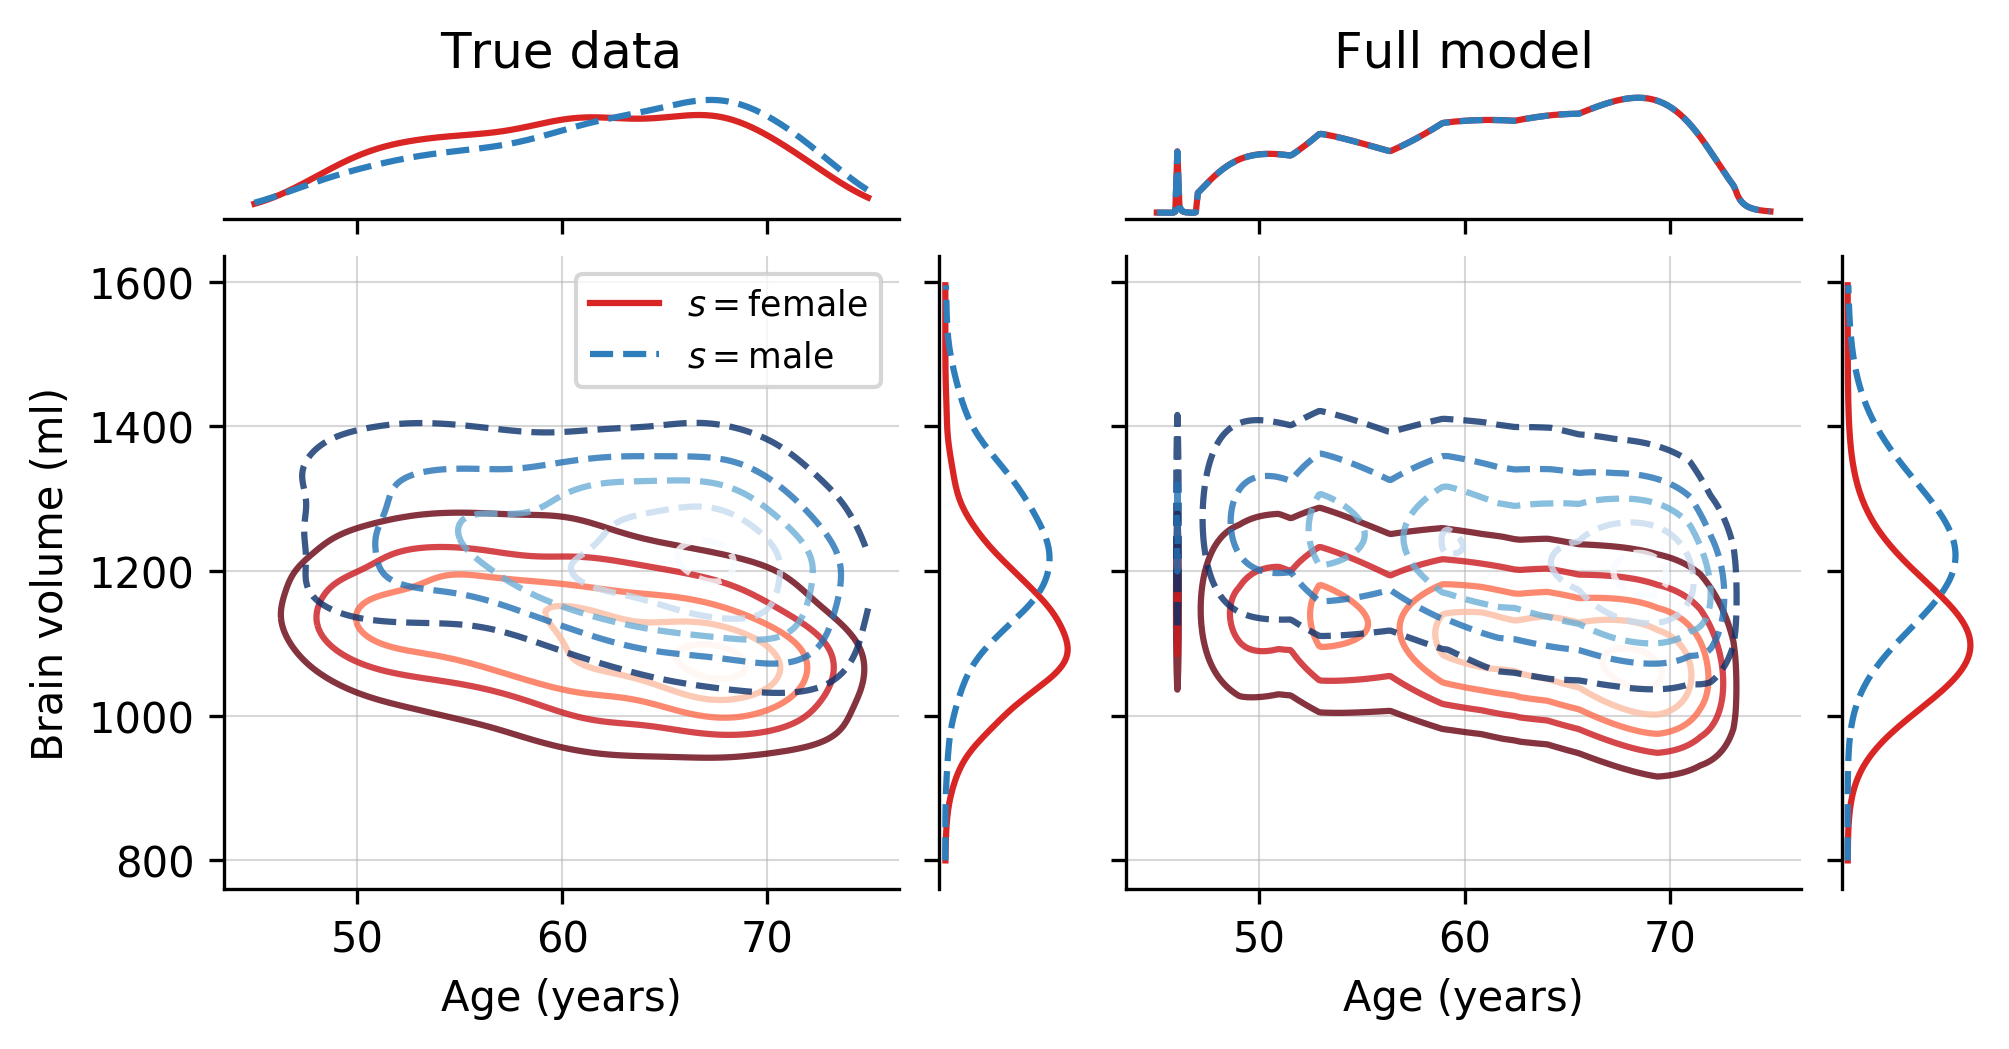

In [18]:
def make_transparent_cmap(cmap):
    n = 256
    colours = cmap(np.linspace(0, 1, n))
    colours[:, -1] = np.linspace(0, 1, n)
    return ListedColormap(colours)    

def plot_exp(i, exp, ax_joint, ax_marg_x, ax_marg_y):
    contours = []
    for j, (k, v) in enumerate(prob_maps[exp].items()):
        shape = (age_range.shape[0], bvol_range.shape[0])
        age = v['age'].reshape(shape).numpy()
        bvol = v['brain_volume'].reshape(shape).numpy() / 1000
        log_prob = v['log_prob'].reshape(shape).numpy()
        prob = np.exp(log_prob)

        da = age[1, 0] - age[0, 0]
        db = bvol[0, 1] - bvol[0, 0]
        marg_a = prob.sum(1) * da
        marg_b = prob.sum(0) * db * 1000

        mi = prob.min()
        ma = np.percentile(prob.flat, 99.5)
        step = (ma - mi) / 5
        levels = np.arange(mi, ma, step) + step

        filled = False#j == 0
        dashed = j == 1
        cmap = cmaps[j]
        colour = cmap(.7)

        alpha = .8
        if filled:
            ax_joint.contourf(age, bvol, prob, cmap=cmap, antialiased=True, levels=levels, alpha=alpha, extend='max')
            c = ax_marg_x.fill_between(age[:, 0], marg_a, color=colour, lw=0, alpha=alpha)
            ax_marg_y.fill_betweenx(bvol[0, :], marg_b, color=colour, lw=0, alpha=alpha)
        else:
            kwargs = dict(cmap=cmap.reversed(), antialiased=True, levels=levels, alpha=alpha)
            if dashed:
                kwargs['linestyles'] = 'dashed'
            c = ax_joint.contour(age, bvol, prob, **kwargs)

        kwargs = dict(ls='--') if dashed else {}
        h, = ax_marg_x.plot(age[:, 0], marg_a, c=colour, **kwargs)
        ax_marg_y.plot(marg_b, bvol[0, :], c=colour, **kwargs)

        if filled:
            contours.append(c)
        else:
            contours.append(h)

    ax_marg_x.set_title(titles[exp])
    ax_joint.set_xlabel('Age (years)', fontsize='medium')
    if i == 0:
        ax_joint.set_ylabel('Brain volume (ml)', fontsize='medium')
        ax_joint.legend(contours, prob_maps[exp].keys(), fontsize='small')

def plot_all_joints():
    n_exp = len(titles)
    fig = plt.figure(figsize=(6.8, 3.6))
    ratio = 5
    global_gs = fig.add_gridspec(1, n_exp)
    
    ax_joint0 = ax_marg_x0 = ax_marg_y0 = None

    margin = 0.02 / n_exp
    width = 1. / n_exp
    for i, exp in enumerate(titles.keys()):
        gs = global_gs[i].subgridspec(2, 2, width_ratios=[ratio, 1], height_ratios=[1, ratio],
                                   wspace=0.1, hspace=0.1)

        ax_joint = fig.add_subplot(gs[1, 0], sharex=ax_joint0, sharey=ax_joint0)
        ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint0, sharey=ax_marg_x0)
        ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint0, sharex=ax_marg_y0)
        if i == 0:
            ax_joint0 = ax_joint
            ax_marg_x0 = ax_marg_x
            ax_marg_y0 = ax_marg_y
        
        plt.setp(ax_marg_x.get_xticklabels(), visible=False)
        plt.setp(ax_marg_y.get_yticklabels(), visible=False)
        
        # Turn off the ticks on the density axis for the marginal plots
        plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax_marg_x.get_yticklabels(), visible=False)
        plt.setp(ax_marg_y.get_xticklabels(), visible=False)
        for s in ['top', 'right']:
            ax_joint.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax_marg_x.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax_marg_y.spines[s].set_visible(False)
        ax_marg_x.yaxis.grid(False)
        ax_marg_y.xaxis.grid(False)
        
        if i > 0:
            plt.setp(ax_joint.get_yticklabels(), visible=False)
            
        ax_joint.grid('on', lw=.5, alpha=.5)

        plot_exp(i, exp, ax_joint, ax_marg_x, ax_marg_y)
    
    fig.tight_layout()

titles = {'true': 'True data', 'model': 'Full model'}
plot_all_joints()
plt.savefig(f'{FIGURE_SAVE_PATH}/medical_age_bvol.pdf', bbox_inches='tight')

# Age, Brain, Ventricle KDE

In [19]:
age_range = torch.arange(45, 75, 0.2, dtype=torch.float)
bvol_range = torch.arange(8e5, 17e5, 5e3, dtype=torch.float)
vvol_range = torch.arange(0, 1e5, 1e3, dtype=torch.float)[:-1]

age_range_, vvol_range_, bvol_range_ = torch.meshgrid(age_range, vvol_range, bvol_range)

bvol_bounds = [(8e5, 10e5), (10e5, 12e5), (12e5, 14e5), (14e5, 16e5)]

prob_maps = {'model': {}}
for (bvol_lo, bvol_hi) in bvol_bounds:
    sel = (bvol_range >= bvol_lo) & (bvol_range < bvol_hi)
    cond_data = {
        'age': age_range_[:, :, sel].view(-1, 1),
        'ventricle_volume': vvol_range_[:, :, sel].view(-1, 1),
        'brain_volume': bvol_range_[:, :, sel].view(-1, 1),
    }

    log_probs = []
    for sex in [0, 1]:
        cond_data['sex'] = torch.full_like(cond_data['age'], float(sex))

        with torch.no_grad():
            trace = pyro.poutine.trace(pyro.condition(pgm_model, data=cond_data)).get_trace(cond_data['age'].shape[0])
            trace.compute_log_prob()

        log_probs.append(trace.nodes['age']['log_prob'] + trace.nodes['ventricle_volume']['log_prob'])

    sex_prob = torch.sigmoid(loaded_models[model_name].sex_logits)
    log_prob = torch.log(sex_prob * log_probs[0].exp() + (1.-sex_prob) * log_probs[1].exp())
    prob_maps['model'][f"$b\in[{bvol_lo/1000:g},{bvol_hi/1000:g})$"] = {
        'age': trace.nodes['_RETURN']['value'][0],
        'ventricle_volume': trace.nodes['_RETURN']['value'][2],
        'brain_volume': trace.nodes['_RETURN']['value'][3],
        'log_prob': log_prob.reshape(age_range_[:, :, sel].shape)
    }
    
prob_maps['true'] = {}
for (bvol_lo, bvol_hi) in bvol_bounds:
    sel = (ukbb_test.metrics['brain_volume'] >= bvol_lo) & (ukbb_test.metrics['brain_volume'] < bvol_hi)
    data = torch.stack([ukbb_test.metrics['age'][sel],
                        ukbb_test.metrics['ventricle_volume'][sel]], -1).numpy()
    kde = gaussian_kde(data.T)
    log_prob = np.log(kde(torch.stack([x.flatten() for x in torch.meshgrid(age_range, vvol_range)], 0)))
    prob_maps['true'][f"$b\in[{bvol_lo/1000:g},{bvol_hi/1000:g})$"] = {
        'age': age_range_,
        'ventricle_volume': vvol_range_,
        'log_prob': torch.as_tensor(log_prob.reshape(age_range.shape[0], vvol_range.shape[0]))
    }

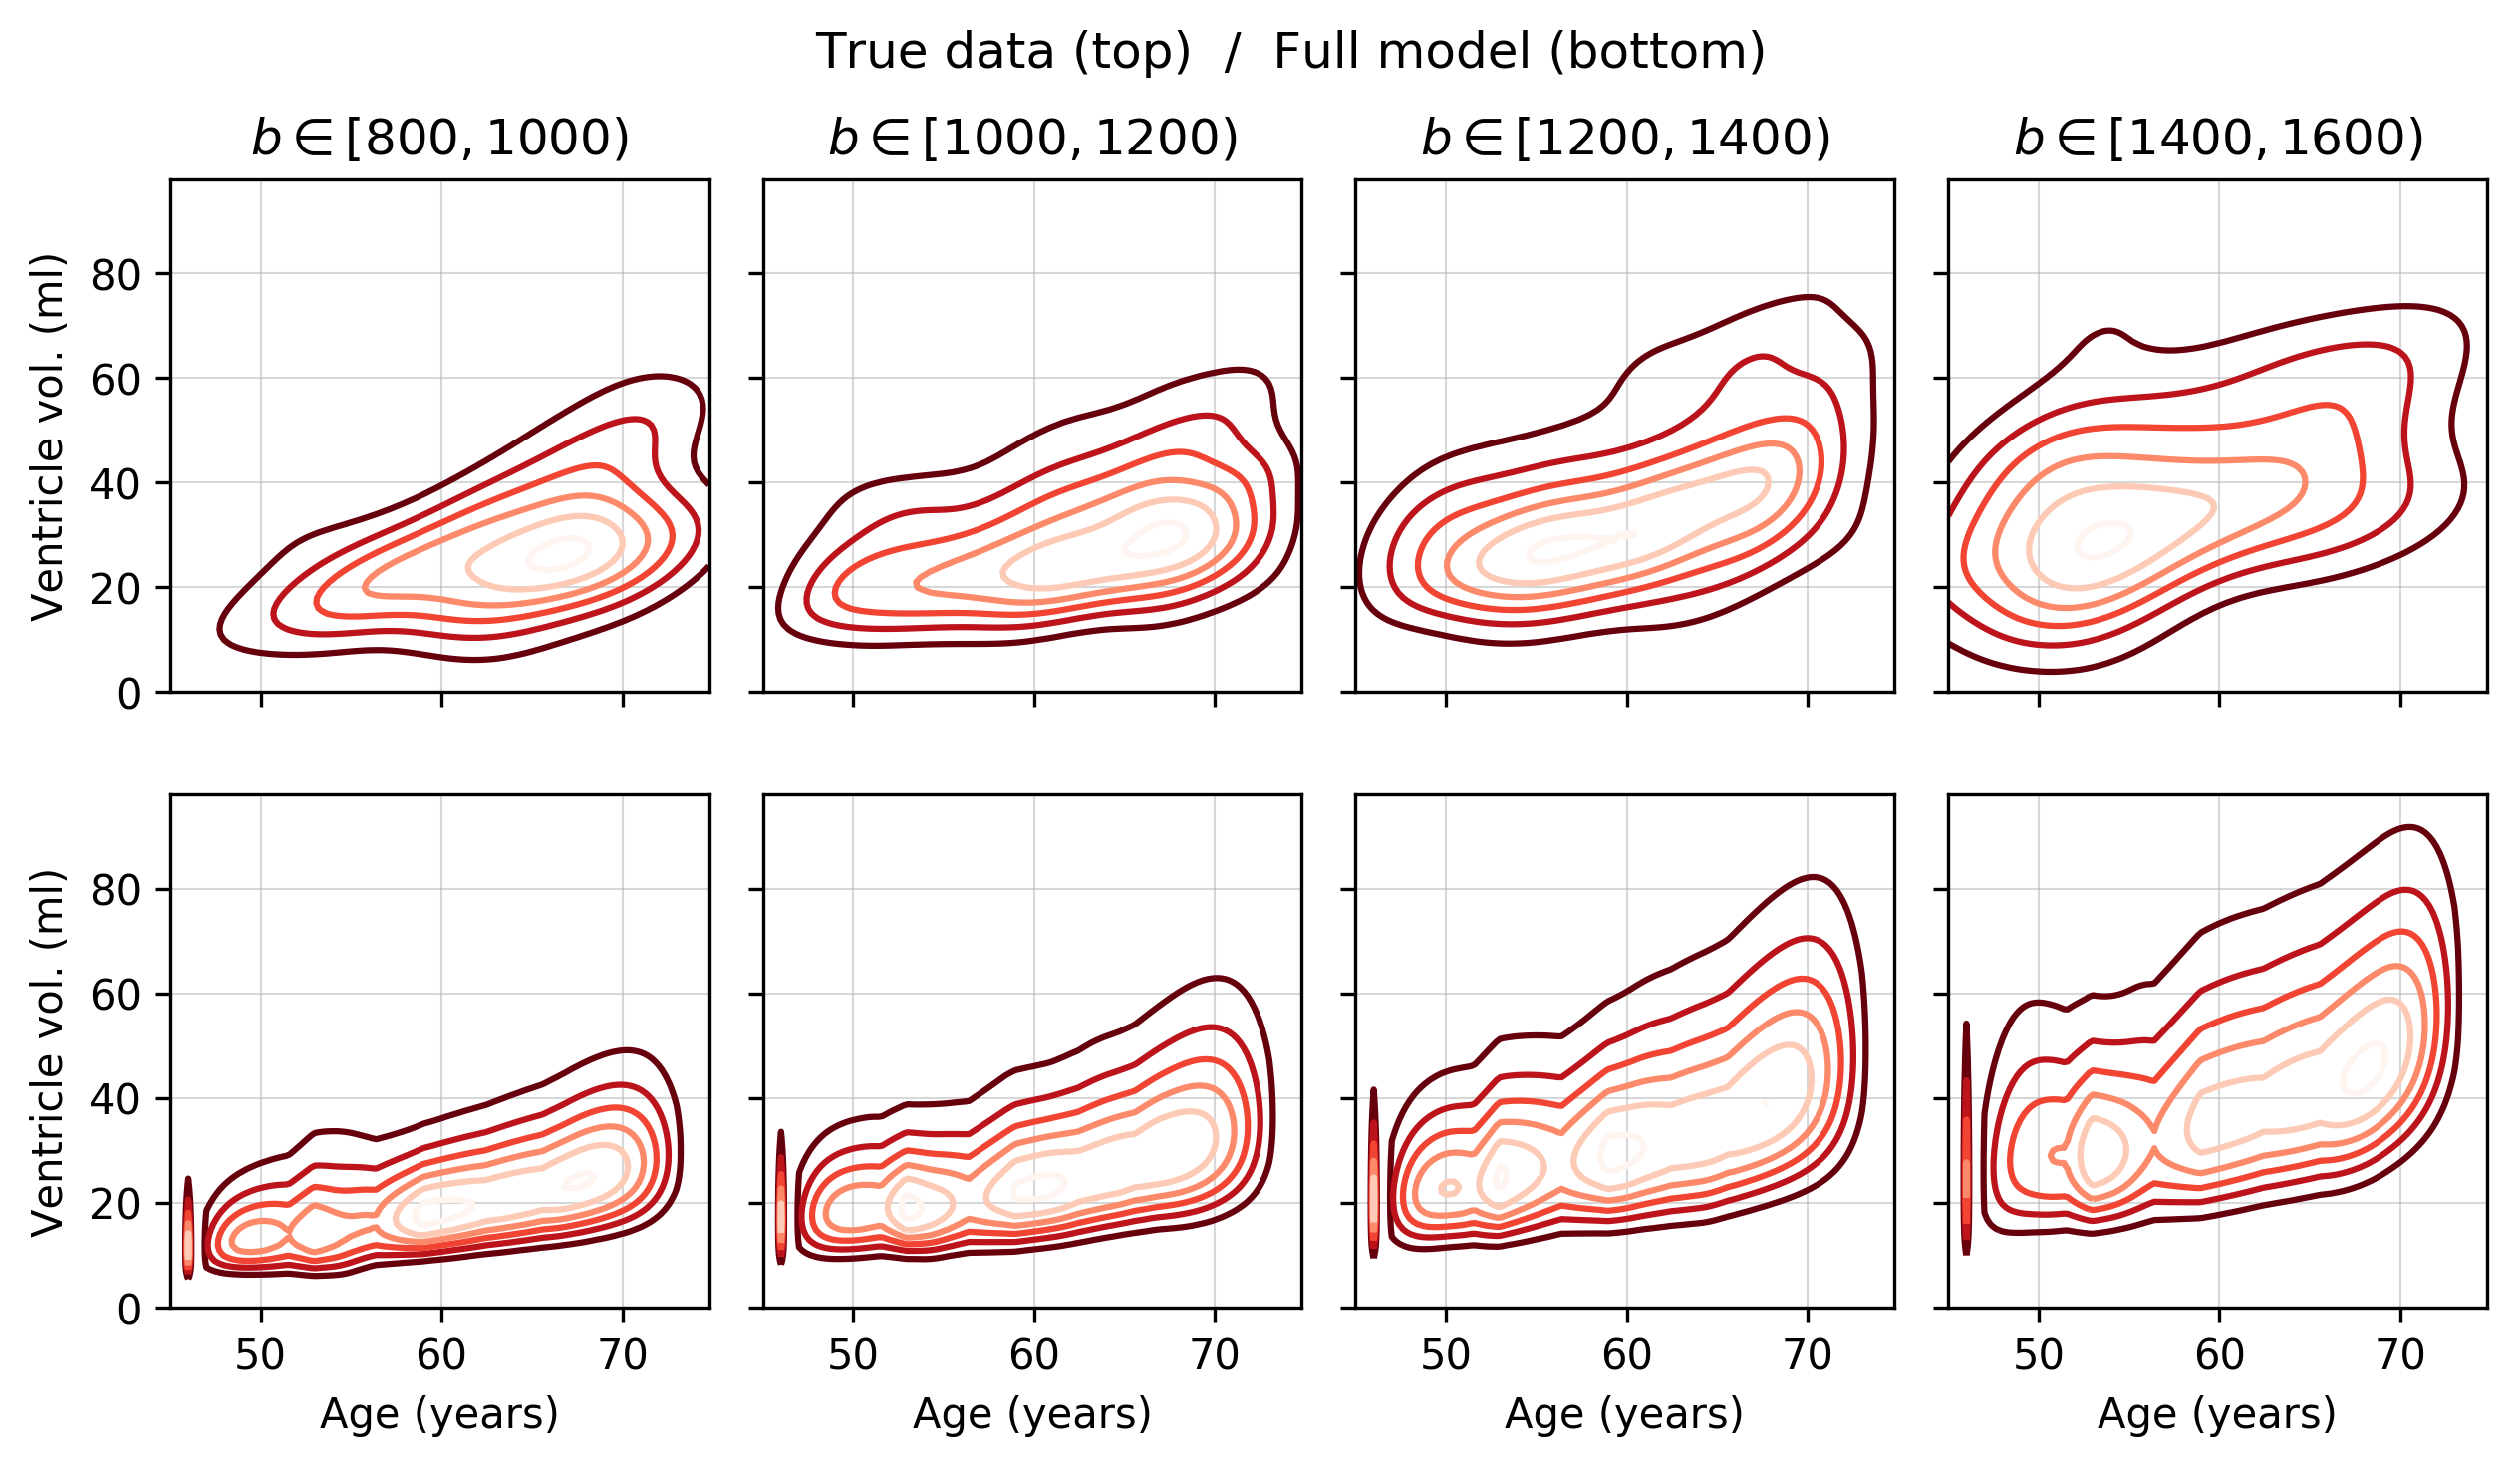

In [20]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True, gridspec_kw=dict(wspace=.1))

def plot_joint_pdf(x, y, logp, ax, filled=False, **kwargs):
    prob = np.exp(logp.numpy()).T

    valid = np.isfinite(prob)
    mi = prob[valid].min()
    ma = np.percentile(prob[valid].flat, 99.5)
    step = (ma - mi) / 6
    levels = np.arange(mi, ma, step) + step

    if filled:
        ax.contourf(x, y, prob, cmap=cmaps[0], levels=levels, extend='max', **kwargs)
    else:
        ax.contour(x, y, prob, cmap=cmaps[0].reversed(), levels=levels, extend='max', **kwargs)
    ax.grid('on', lw=.5, alpha=.5)

for (k, v), ax in zip(prob_maps['true'].items(), axs[0]):
    plot_joint_pdf(age_range, vvol_range/1000, v['log_prob'], ax, filled=False)
    ax.set_title(k)
    
for (k, v), ax in zip(prob_maps['model'].items(), axs[1]):
    plot_joint_pdf(age_range, vvol_range/1000, v['log_prob'].logsumexp(-1), ax, filled=False)

for ax in axs[1]:
    ax.set_xlabel("Age (years)", fontsize='medium')
for ax in axs[:, 0]:
    ax.set_ylabel("Ventricle vol. (ml)", fontsize='medium')
fig.suptitle("True data (top)  /  Full model (bottom)", va='top')

plt.savefig(f'{FIGURE_SAVE_PATH}/medical_age_vvol.pdf', bbox_inches='tight')

# Counterfactuals

In [21]:
def plot_intervention_range(bp, interventions, idx, normalise_all=True):
    fig, ax = plt.subplots(3, len(interventions), figsize=(1.6 * len(interventions), 5), gridspec_kw=dict(wspace=0, hspace=0))
    lim = 0
    
    imgs = []
    for intervention in interventions:
        f = os.path.join(bp, f'{intervention}.pt')
        samples = torch.load(f)

        main_intervention = intervention[3:].split('=')[0]

        imgs += [samples['x'][idx]]
        
        x_test = (ukbb_test[idx]['image'] * 255.)
        diff = (x_test - imgs[-1]).squeeze()

        lim = np.maximum(lim, diff.abs().max())

    for i, intervention in enumerate(interventions):
        
        main_intervention = intervention[3:].split('=')[0]
        
        val = ukbb_test[idx][main_intervention].item()

        v_name = var_name[main_intervention]
        v_val = value_fmt[main_intervention](val)
        i_val = value_fmt[main_intervention](float(intervention[3:-1].split('=')[1]))
        
        x = imgs[i]
        x_test = (ukbb_test[idx]['image'] * 255.)
        diff = (x_test - x).squeeze()
        if not normalise_all:
            lim = diff.abs().max()

        ax[0, i].imshow(x_test.squeeze(), 'Greys_r')
        
        ax[0, i].set_title(f"$do({v_name}={i_val})$", fontsize=12)
        ax[1, i].imshow(x.squeeze(), 'Greys_r')

        ax[2, i].imshow(diff, 'seismic', clim=[-lim, lim])

        for axi in ax[:, i]:
            axi.axis('off')
            axi.xaxis.set_major_locator(plt.NullLocator())
            axi.yaxis.set_major_locator(plt.NullLocator())

    
    suptitle = '$s={sex}; a={age}; b={brain_volume}; v={ventricle_volume}$'.format(
        **{att: value_fmt[att](ukbb_test[idx][att].item()) for att in ('sex', 'age', 'brain_volume', 'ventricle_volume')}
    )
    fig.suptitle(suptitle, fontsize=16, y=1.04)
    

    fig.tight_layout()

    plt.savefig(f"{FIGURE_SAVE_PATH}/intervention_range_{idx}_normalised_{normalise_all}.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

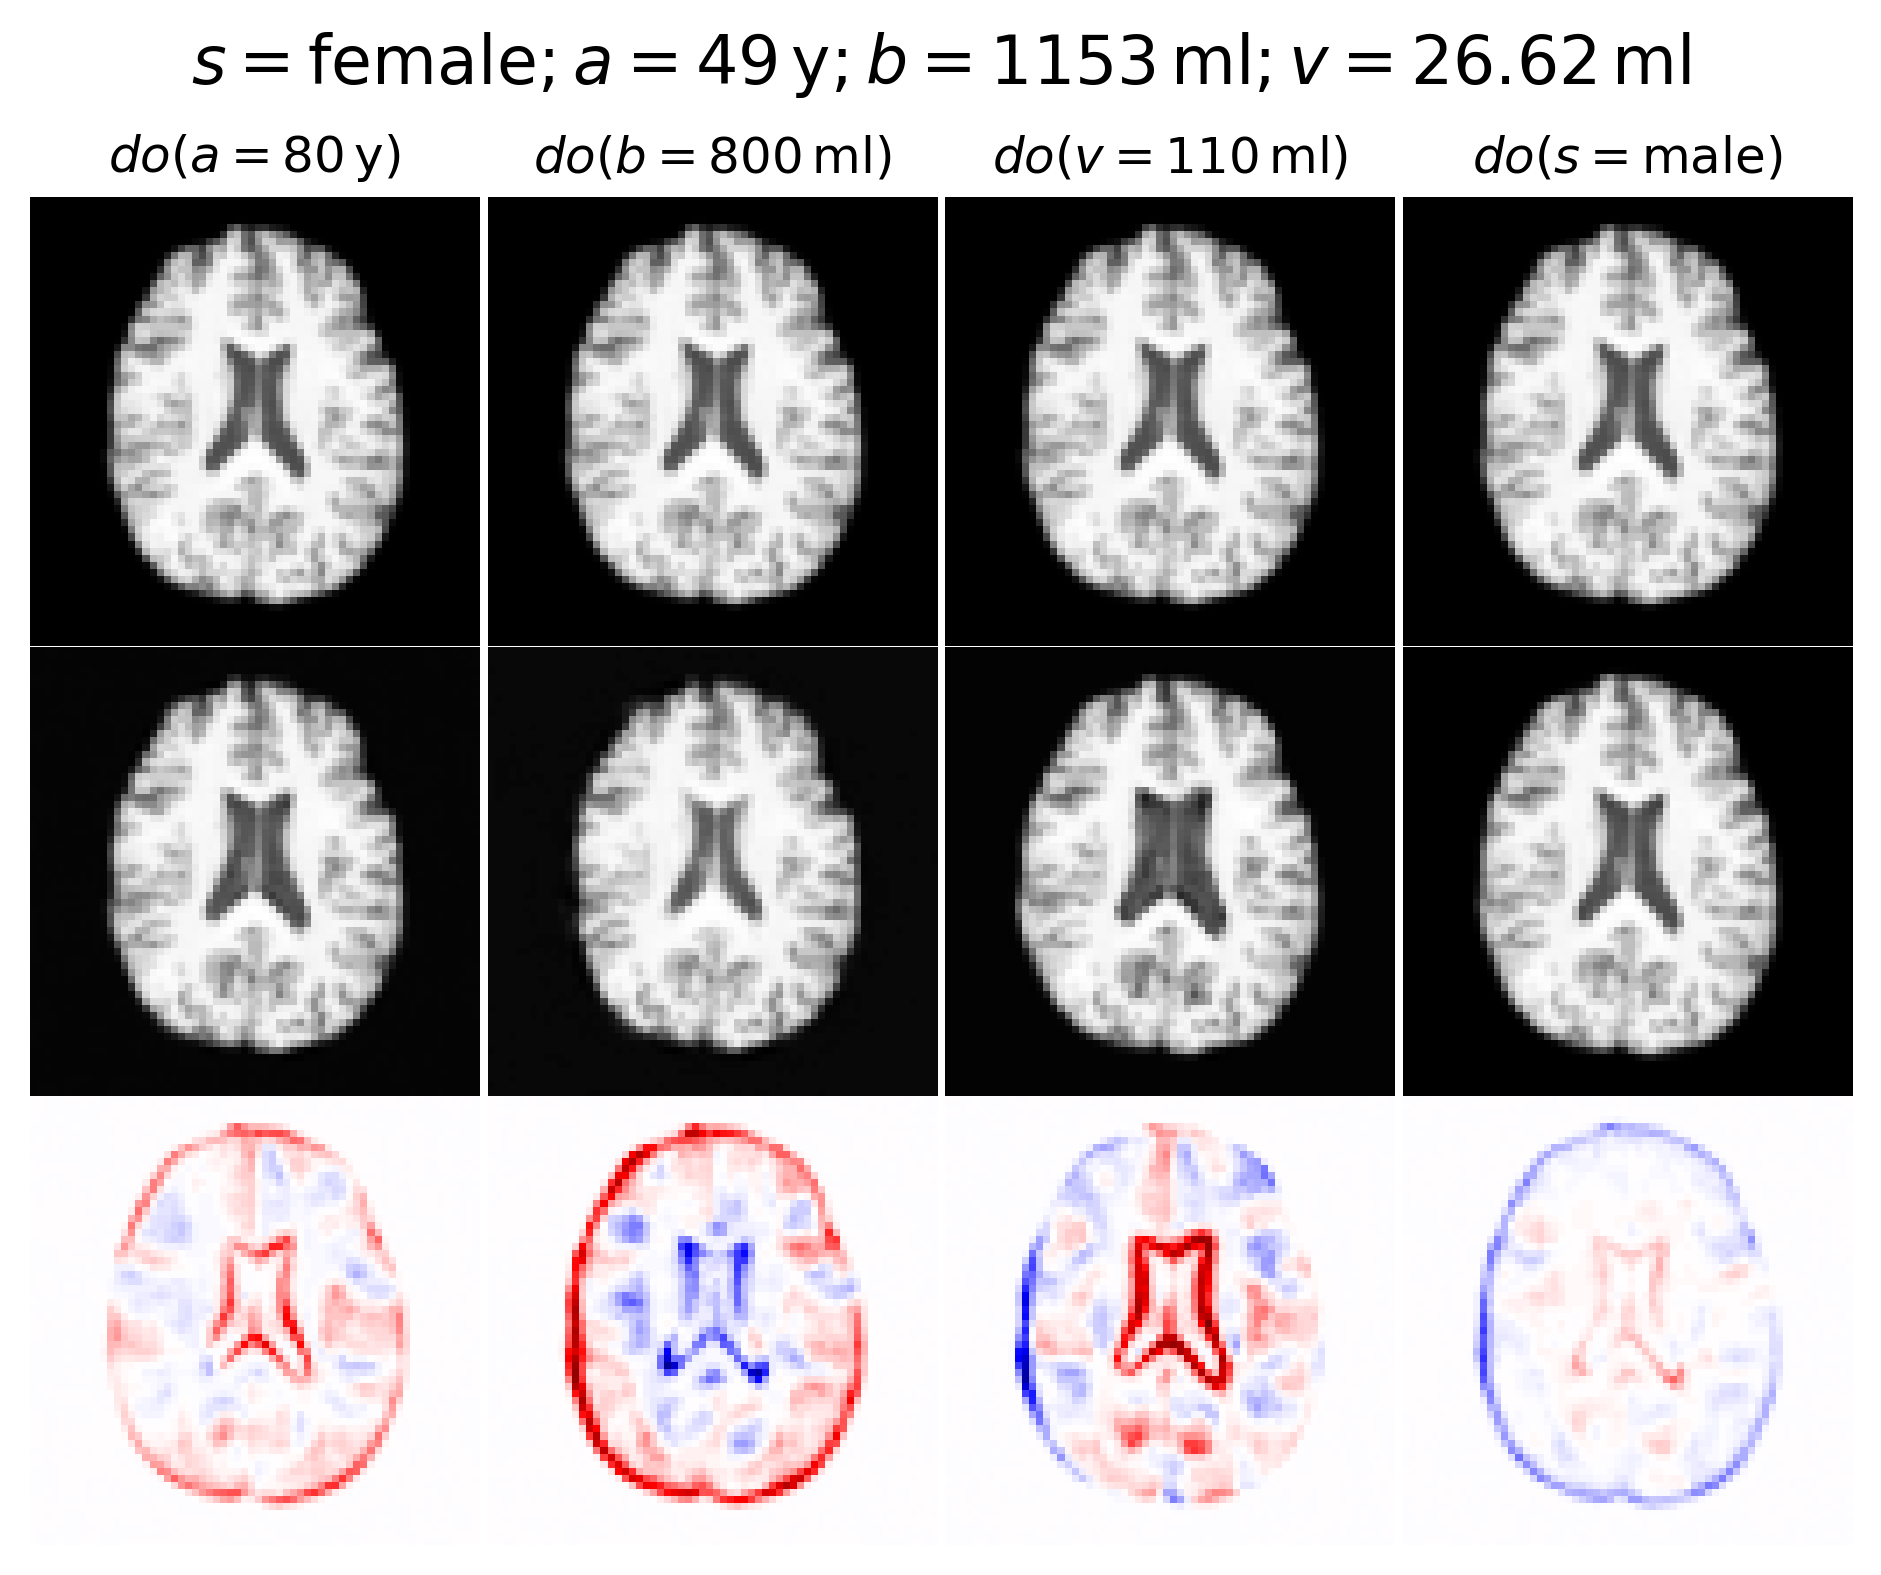

In [22]:
wanted_dos = ['do(age=80)', 'do(brain_volume=800000)', 'do(ventricle_volume=110000)', 'do(sex=1)']
for idx in [1337]:
    bp = f'{BASE_LOG_PATH}/ConditionalVISEM/version_0/'
    plot_intervention_range(bp, wanted_dos, idx, True)

# Counterfactual Traversals

In [23]:
def plot_gen_intervention_range(model_name, all_interventions, save_name, normalise_all=True, num_samples=32):
    
    
    num_idx = len(all_interventions)
    num_inter = len(all_interventions[0][1])
    
    hrs = [0.2 if ((i + 1) % 3) == 0 else 1 for i in range(2 * num_idx + num_idx - 1)]
    fig, ax = plt.subplots(2 * num_idx + num_idx - 1, (num_inter + 1), figsize=(1.8 * (num_inter + 1), 4*num_idx),
                           gridspec_kw=dict(wspace=0, hspace=0, height_ratios=hrs))
    lim = 0
    
    for cur_ex, (idx, interventions) in enumerate(all_interventions):
        orig_data = prep_data(ukbb_test[idx])

        imgs = []
        for intervention in interventions:
            pyro.clear_param_store()
            cond = {k: torch.tensor([[v]]) for k, v in intervention.items()}
            counterfactual = loaded_models[model_name].counterfactual(orig_data, cond, num_samples)

            imgs += [counterfactual['x']]

            diff = (orig_data['x'] - imgs[-1]).squeeze()

            lim = np.maximum(lim, diff.abs().max())
            
        x_test = orig_data['x']
        ax[cur_ex * 3, 0].imshow(x_test.squeeze(), 'Greys_r', vmin=0, vmax=255)
        ax[cur_ex * 3, 0].set_title('Original')

        for i, intervention in enumerate(interventions):
            x = imgs[i]
            
            diff = (x_test - x).squeeze()
            if not normalise_all:
                lim = diff.abs().max()

            ax[cur_ex * 3, i + 1].set_title(fmt_intervention(intervention))
            ax[cur_ex * 3, i + 1].imshow(x.squeeze(), 'Greys_r', vmin=0, vmax=255)

            ax[cur_ex * 3 + 1, i + 1].imshow(diff, 'seismic', clim=[-lim, lim])
        
        att_str = '$s={sex}$\n$a={age}$\n$b={brain_volume}$\n$v={ventricle_volume}$'.format(
            **{att: value_fmt[att](orig_data[att].item()) for att in ('sex', 'age', 'brain_volume', 'ventricle_volume')}
        )
        
        ax[cur_ex * 3 + 1, 0].text(0.5, 0.5, att_str, horizontalalignment='center',
                                   verticalalignment='center', transform=ax[cur_ex * 3 + 1, 0].transAxes,
                                   fontsize=mpl.rcParams['axes.titlesize'])
        
    for axi in ax.ravel():
        axi.axis('off')
        axi.xaxis.set_major_locator(plt.NullLocator())
        axi.yaxis.set_major_locator(plt.NullLocator())

    plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.pdf", bbox_inches='tight', pad_inches=0)
        
    plt.show()

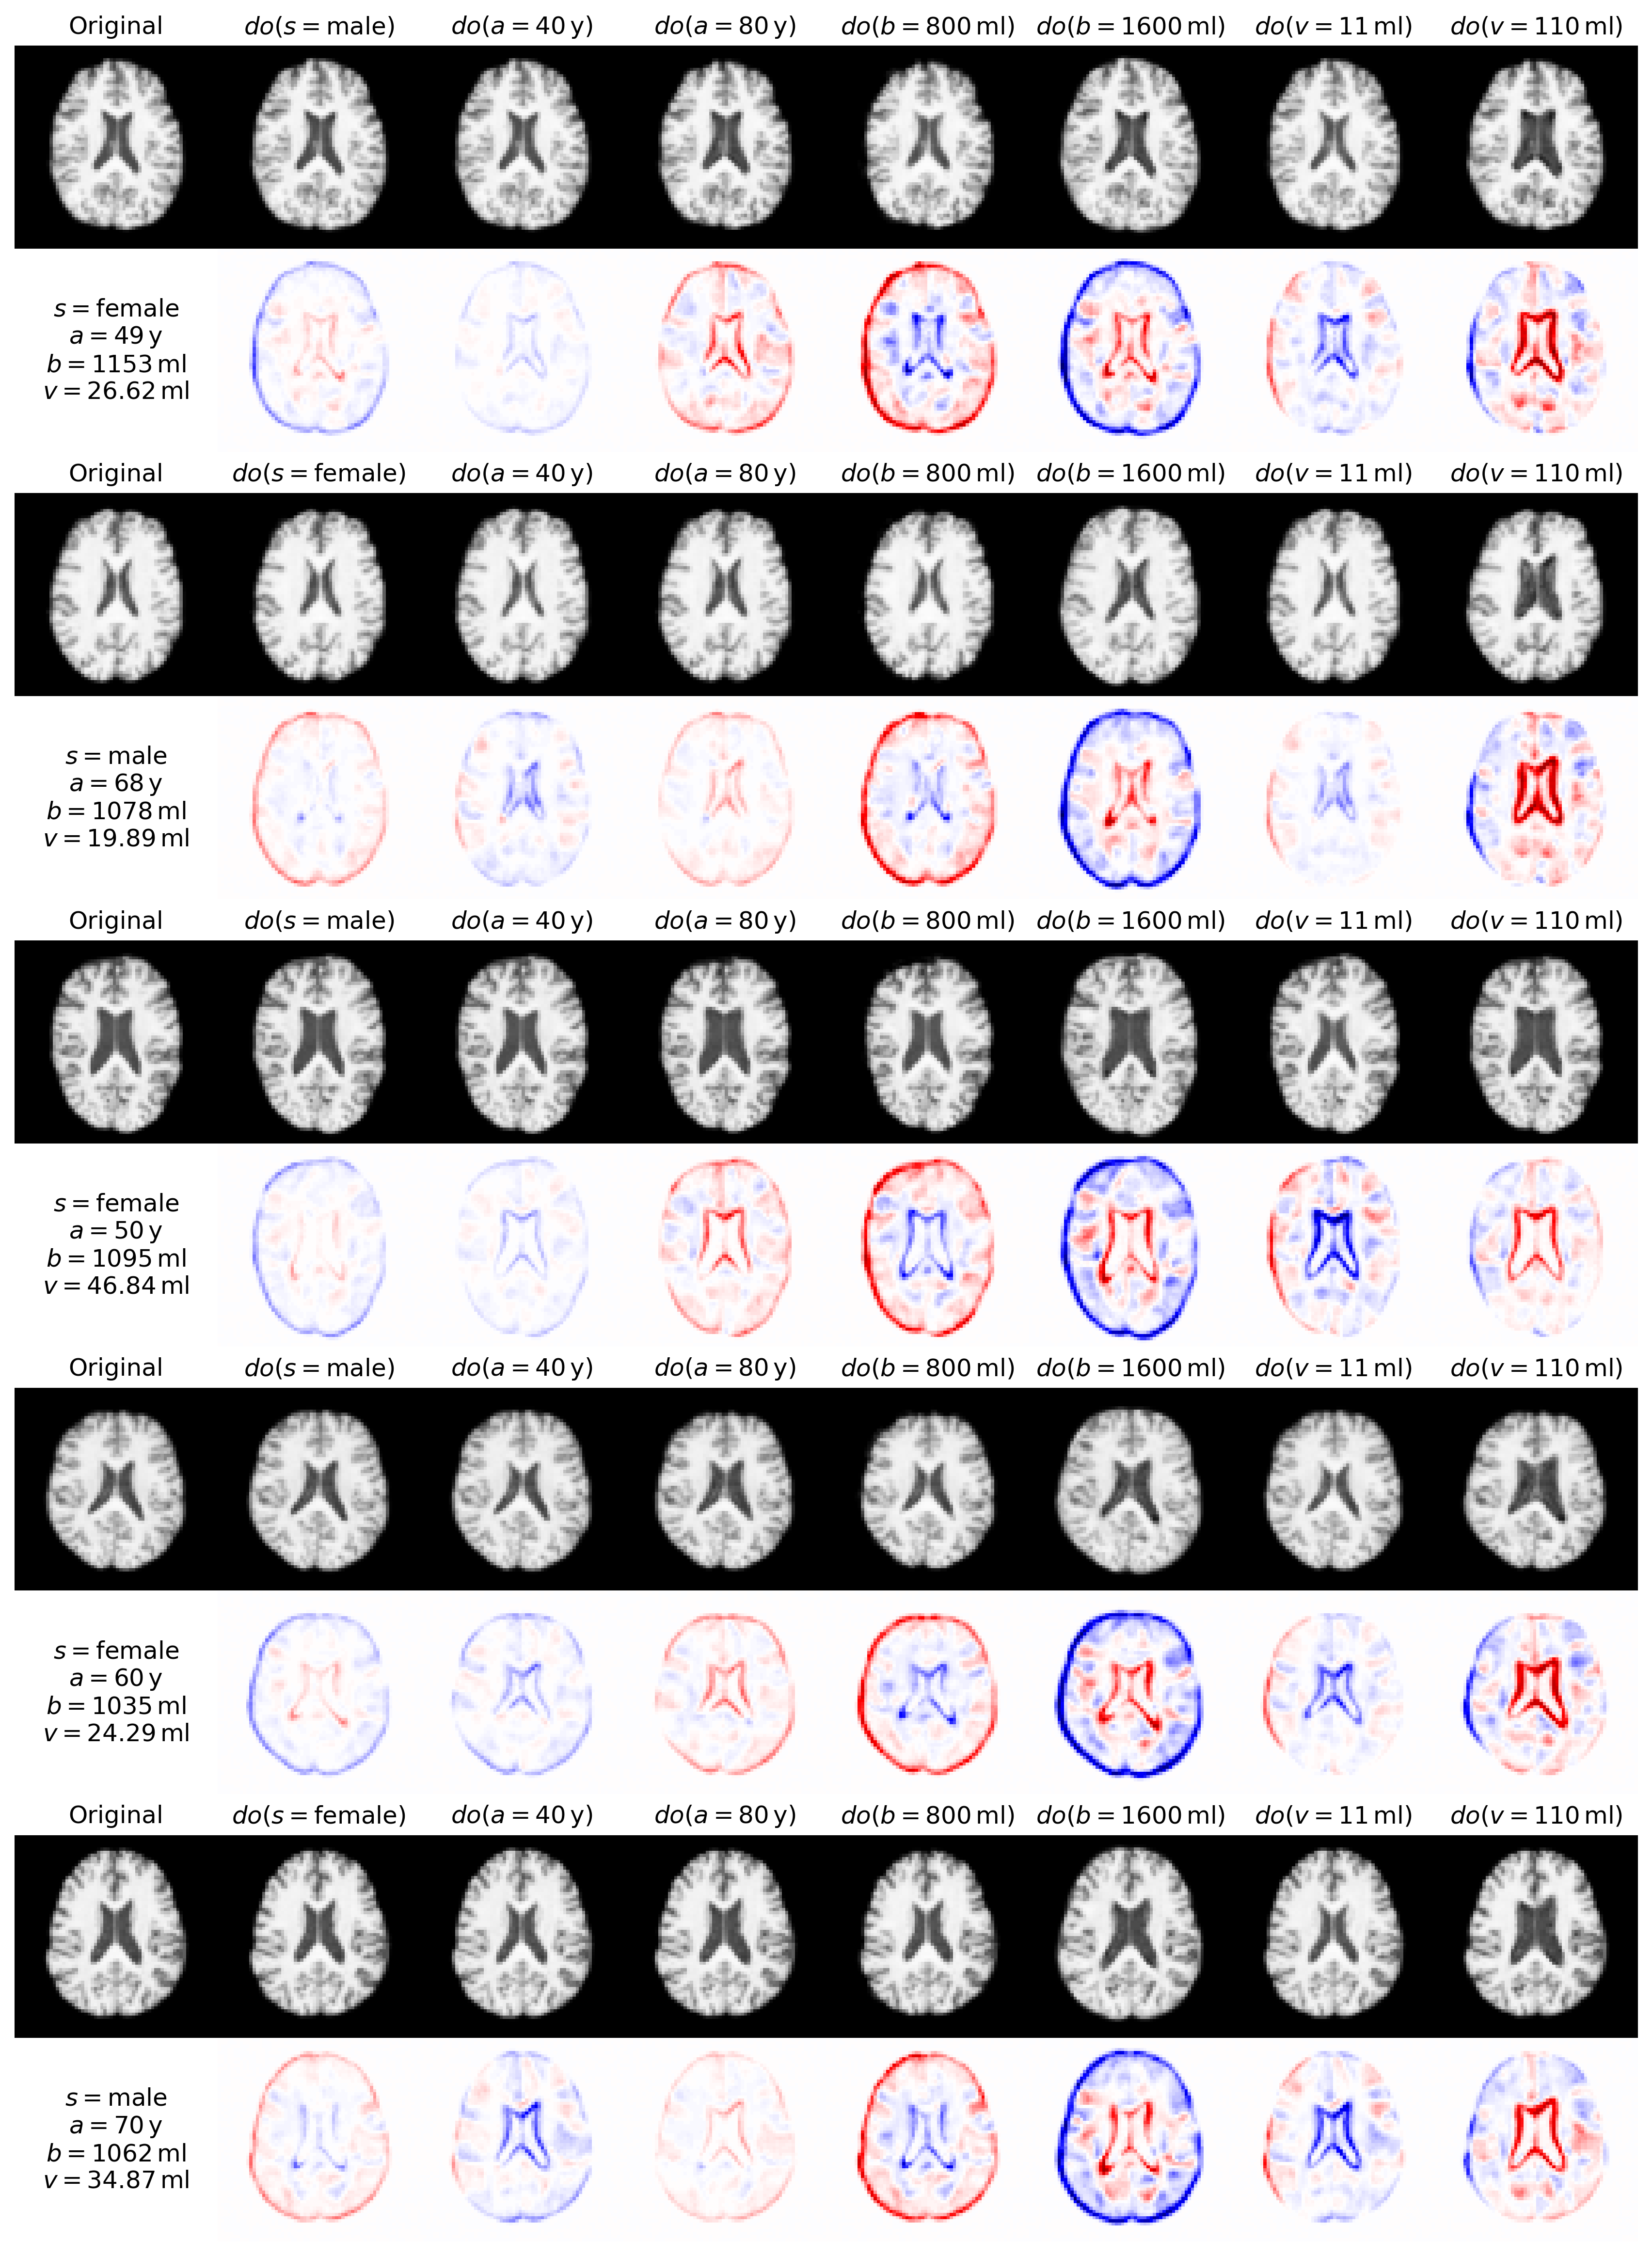

In [24]:
idx = 1337
model_name = 'ConditionalVISEM'

orig_data = prep_data(ukbb_test[idx])

interventions = [
    (1337, [
        {'sex': 1.},
        {'age': 40.},
        {'age': 80.},
        {'brain_volume': 800000.},
        {'brain_volume': 1600000.},
        {'ventricle_volume': 11000.},
        {'ventricle_volume': 110000.},
    ]),
    (13, [
        {'sex': 0.},
        {'age': 40.},
        {'age': 80.},
        {'brain_volume': 800000.},
        {'brain_volume': 1600000.},
        {'ventricle_volume': 11000.},
        {'ventricle_volume': 110000.},
    ]),
    (42, [
        {'sex': 1.},
        {'age': 40.},
        {'age': 80.},
        {'brain_volume': 800000.},
        {'brain_volume': 1600000.},
        {'ventricle_volume': 11000.},
        {'ventricle_volume': 110000.},
    ]),
    (1, [
        {'sex': 1.},
        {'age': 40.},
        {'age': 80.},
        {'brain_volume': 800000.},
        {'brain_volume': 1600000.},
        {'ventricle_volume': 11000.},
        {'ventricle_volume': 110000.},
    ]),
    (666, [
        {'sex': 0.},
        {'age': 40.},
        {'age': 80.},
        {'brain_volume': 800000.},
        {'brain_volume': 1600000.},
        {'ventricle_volume': 11000.},
        {'ventricle_volume': 110000.},
    ]),
]

save_name = 'counterfactual_range'

plot_gen_intervention_range(model_name, interventions, save_name, normalise_all=True, num_samples=32)
